# Converting an ANN to an SNN

This tutorial walks you through how to convert your pre-trained model to a spiking version.
Lets start by installing all the necessary packages. 

## Defining an ANN
We define a simple convolutional architecture.

In [1]:
import torch.nn as nn

ann = nn.Sequential(
    nn.Conv2d(1, 20, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Conv2d(20, 32, 5, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Conv2d(32, 128, 3, 1, bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(128, 500, bias=False),
    nn.ReLU(),
    nn.Linear(500, 10, bias=False),
)

## Define a custom dataset

We'll need to fine-tune our model on our dataset of choice. Here we'll use MNIST. Since we intend to do a spiking neural network simulation, we override this `Dataset` to also *optionally* return a `spike raster` instead of an image. 

In this implementation of the `Dataset` we use *rate coding* to generate a series of spikes at each pixel of the image proportional to it's gray level.

In [2]:
import torch
from torchvision import datasets, transforms


class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, is_spiking=False, time_window=100):
        super().__init__(
            root=root, train=train, download=True, transform=transforms.ToTensor()
        )
        self.is_spiking = is_spiking
        self.time_window = time_window

    def __getitem__(self, index):
        img, target = self.data[index].unsqueeze(0) / 255, self.targets[index]
        # img is now a tensor of 1x28x28

        if self.is_spiking:
            img = (torch.rand(self.time_window, *img.shape) < img).float()

        return img, target

### Fine-tune the ANN

We'll make sure that classification accuracy is high enough with this model on MNIST. Note here that we are not yet using spiking input (`spiking=False`). This is vanilla training for standard image classification.

In [3]:
from torch.utils.data import DataLoader

mnist_train = MNIST("./data", train=True, is_spiking=False)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

mnist_test = MNIST("./data", train=False, is_spiking=False)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

We iterate over our data loader `train_loader` and train our parameters using the `Adam` optimizer with a learning rate of `1e-4`. Since the last layer in our network has no specific activation function defined, `cross_entropy` loss is a good candidate to train our network.

In [4]:
from tqdm.auto import tqdm
import torch
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

ann = ann.to(device)
ann.train()

optim = torch.optim.Adam(ann.parameters(), lr=1e-3)

n_epochs = 2

for n in tqdm(range(n_epochs)):
    for data, target in iter(train_loader):
        data, target = data.to(device), target.to(device)
        output = ann(data)
        optim.zero_grad()

        loss = F.cross_entropy(output, target)
        loss.backward()
        optim.step()

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
correct_predictions = []

for data, target in iter(test_loader):
    data, target = data.to(device), target.to(device)
    output = ann(data)

    # get the index of the max log-probability
    pred = output.argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))

correct_predictions = torch.cat(correct_predictions)
print(
    f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
)

Classification accuracy: 97.86%


Training this model on `MNIST` is fairly straight forward and you should reach accuracies of around `>98%` within a small number of epochs. In the script above we only train for 3 epochs!

###  Model conversion to SNN

Up until this point we have only operated on images using standard CNN architectures. Now we look at how to build an equivalent spiking convolutional neural network (`SCNN`).

`sinabs` has a handy method for this. Given a standard CNN model, the `from_model` method in `sinabs` that converts it into a spiking neural network. It is a *one liner*! 

In [6]:
from sinabs.from_torch import from_model

input_shape = (1, 28, 28)

sinabs_model = from_model(
    ann, input_shape=input_shape, add_spiking_output=True, synops=False
)

You can see that this method takes two more parameters in addition to the model to be converted.

`input_shape` is needed in order to instantiate a SNN with the appropriate number of neurons because unlike traditional CNNs, SNNs are *stateful*.

`add_spiking_output` is a boolean flag to specify whether or not to add a spiking layer as the last layer in the network. This ensure that both the input and output to our network are of the form of `spikes`.

`synops=True` tells sinabs to include the machinery for calculating synaptic operations, which we'll use later.

Let us now look at the generated SCNN. You should see that the only major difference is that the `ReLU` layers are replaced by `SpikingLayer`.

In [7]:
sinabs_model.spiking_model

Sequential(
  (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (1): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1.0)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(20, 32, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (4): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1.0)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (7): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1.0)
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=128, out_features=500, bias=False)
  (11): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1.0)
  (12): Linear(in_features=500, out_features=10, bias=False)
  (Spiking output): IAFSqueeze(spike_threshold=1.0, min_v_mem=-1.0)
)

### Model validation in sinabs simulation

Lets test our SCNN model to verify whether the network is in fact "equivalent" to the CNN model in terms of its performance. As we did previously, we start by defining a data loader (this time it is going to produce spikes, `spiking=True`) and then pass it to our test method.

In [8]:
# Time window per sample
time_window = 100  # time steps
test_batch_size = 10

spike_mnist_test = MNIST(
    "./data", train=False, is_spiking=True, time_window=time_window
)
spike_test_loader = DataLoader(
    spike_mnist_test, batch_size=test_batch_size, shuffle=True
)

Since the spiking simulations are significantly slower on a PC, we are going to limit our test to 300 samples here. You can of course test it on the entire 10k samples if you want to verify that it works.

In [9]:
import sinabs.layers as sl

correct_predictions = []

for data, target in tqdm(spike_test_loader):
    data, target = data.to(device), target.to(device)
    data = sl.FlattenTime()(data)
    with torch.no_grad():
        output = sinabs_model(data)
        output = output.unflatten(
            0, (test_batch_size, output.shape[0] // test_batch_size)
        )

    # get the index of the max log-probability
    pred = output.sum(1).argmax(dim=1, keepdim=True)

    # Compute the total correct predictions
    correct_predictions.append(pred.eq(target.view_as(pred)))
    if len(correct_predictions) * test_batch_size >= 300:
        break

correct_predictions = torch.cat(correct_predictions)
print(
    f"Classification accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%"
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Classification accuracy: 98.66666666666667%


We see that this auto-generated spiking (`sinabs_model`) network's performance is close to that of the `ann`! Yay!

You would have noticed a free parameter that was added `time_window`. This is a critical parameter that determines whether or not your SNN is going to work well. The longer `time_window` is, the more spikes we produce as input and the better the performance of the network is going to be. Feel free to experiment with this parameter and see how this changes your network performance.

### Visualisation of specific example

In [10]:
# Get one sample from the dataloader
img, label = spike_mnist_test[10]

Lets visualize this data, just so we know what to expect. We can do this by collapsing the time dimension of the spike raster returned by the dataloader.

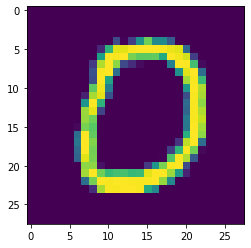

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.imshow(img.sum(0)[0]);

We now take this data (including the time dimension), and pass it to the Sinabs SNN model.

In [12]:
snn_output = sinabs_model(img.to(device))

Let us now display the output in time.

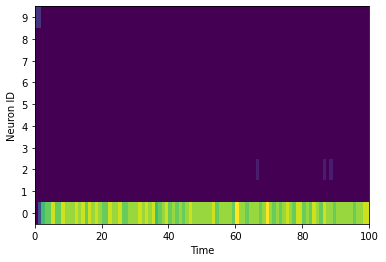

In [13]:
import numpy as np

plt.pcolormesh(snn_output.T.detach().cpu())

plt.ylabel("Neuron ID")
plt.yticks(np.arange(10) + 0.5, np.arange(10))
plt.xlabel("Time");

As you can see, the majority of spikes are emitted by the output neuron corresponding to the digit plotted above, which is a correct inference.